In [116]:
import json
from PIL import Image 
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision.models as models
import torchvision.transforms as transforms

In [117]:
class Normalize(nn.Module):
    def __init__(self, device=torch.device('cpu'), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean).reshape(1, 3, 1, 1)
        self.std = torch.Tensor(std).reshape(1, 3, 1, 1)
    
    def forward(self, x):
        return (x - self.mean) / self.std
    
class Index2Class:
    def __init__(self, filename='imagenet_class_index.json'):
        with open(filename, 'r') as f:
            self.index2class = json.load(f)

In [118]:
model = nn.Sequential(Normalize(),
                        models.vgg16(pretrained=True))

img = Image.open('OBELISK.png').resize((224, 224))
print(img.size)

x = transforms.ToTensor()(img).unsqueeze(0)
x = x[0, :3, :, :]

print(x.type(), x.shape)


/Users/cheng/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cheng/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(224, 224)
torch.FloatTensor torch.Size([3, 224, 224])


In [119]:
model.eval()
x.requires_grad = True
y = torch.LongTensor([682])
logit = model(x)
loss = F.cross_entropy(logit, y)

In [120]:
loss.backward()
print(x.grad.shape)

torch.Size([3, 224, 224])


- 沿着梯度符号方向攻击,生成对抗样本

In [121]:
epsilon = 9/255.0
x_adv = x.data + epsilon*x.grad.data.sign()
x_adv = torch.clamp(x_adv, 0, 1)

- 查看对抗样本的分类结果
  - 方尖碑被网络识别成灯塔，但是人眼几乎感觉不到差别。

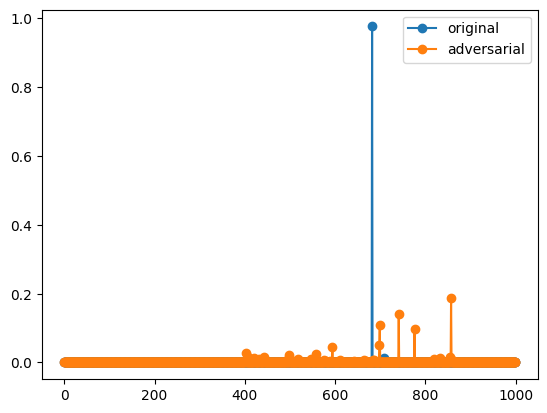

In [122]:
logit = model(x_adv)
prob_adv = F.softmax(logit, dim=1).squeeze().data.numpy()

logit = model(x)
prob = F.softmax(logit, dim=1).squeeze().data.numpy()

plt.plot(prob,'-o',label='original')
plt.plot(prob_adv,'-o',label='adversarial')
plt.legend()


In [123]:
idx2class = Index2Class()
idx = np.argmax(prob_adv)
print(idx2class.index2class[str(idx)])

['n04429376', 'throne']


- 可视化对抗样本

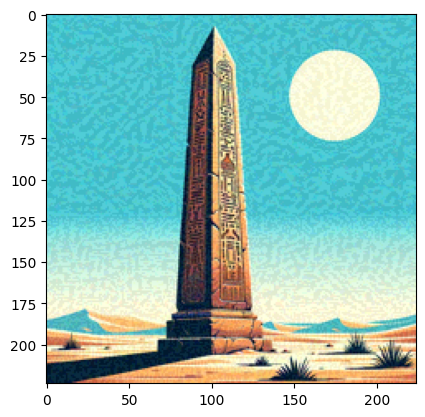

In [124]:
x_np = x_adv.numpy().transpose([1, 2, 0])
plt.imshow(x_np)

有目标攻击

In [125]:
#指定错误类别
Y_WRONG = 120

#计算导数
model.eval()
y = torch.LongTensor([Y_WRONG])
x.grad.zero_()
loss = F.cross_entropy(logit, y)
loss.backward()

#生成对抗样本
epsilon = 9/255.0
x_adv = x.data - epsilon*x.grad.data.sign()
x_adv = torch.clamp(x_adv, 0, 1)

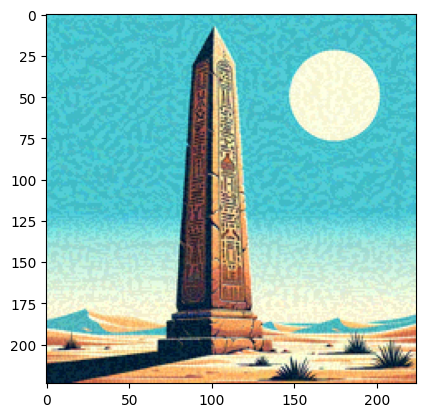

In [126]:
x_np = x_adv.numpy().transpose([1, 2, 0])
plt.imshow(x_np)

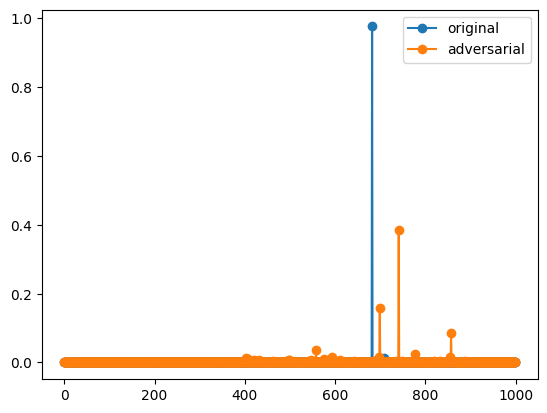

In [127]:
logit = model(x_adv)
prob_adv = F.softmax(logit, dim=1).squeeze().data.numpy()

logit = model(x)
prob = F.softmax(logit, dim=1).squeeze().data.numpy()

plt.plot(prob,'-o',label='original')
plt.plot(prob_adv,'-o',label='adversarial')
plt.legend()


In [128]:
idx_wrong = np.argmax(prob_adv)
print(idx2class.index2class[str(idx_wrong)])

['n03998194', 'prayer_rug']


In [129]:
def multistep_targeted_attack(net,x,y_target,alpha=2/255.0,epsilon =10/255.0,nsteps=5):
    net.eval()
    y_target = torch.LongTensor([y_target])
    J = nn.CrossEntropyLoss()
    x_adv = x.data.clone() 
    x_adv.requires_grad = True
    
    for i in range(nsteps):
        # 计算导数
        if x_adv.grad is not None:
            x_adv.grad.zero_()
        logit = net(x_adv)
        loss = J(logit, y_target)
        loss.backward()
        grad_sign = x_adv.grad.data.sign()
        
        # 一步攻击
        x_adv.data = torch.clamp(x_adv.data - alpha*grad_sign, 0, 1)
        dx = torch.clamp(x_adv.data - x.data, -epsilon, epsilon)
        x_adv.data = x.data + dx
        
        _,pred_label = torch.max(logit.data.view(-1),dim=0)
        print('%d-th, loss: %.2e, pred_label: %d'% (i+1, loss.item(), pred_label))
    return x_adv.data

In [130]:
x_adv = multistep_targeted_attack(model,x,Y_WRONG,
                                  alpha=1/255.0,epsilon =3/255.0,nsteps=20)


1-th, loss: 2.23e+01, pred_label: 682
2-th, loss: 1.31e+01, pred_label: 497
3-th, loss: 9.21e+00, pred_label: 484
4-th, loss: 7.46e+00, pred_label: 484
5-th, loss: 6.33e+00, pred_label: 693
6-th, loss: 6.20e+00, pred_label: 657
7-th, loss: 4.93e+00, pred_label: 693
8-th, loss: 4.58e+00, pred_label: 484
9-th, loss: 3.56e+00, pred_label: 693
10-th, loss: 3.86e+00, pred_label: 767
11-th, loss: 3.78e+00, pred_label: 693
12-th, loss: 2.63e+00, pred_label: 120
13-th, loss: 2.29e+00, pred_label: 693
14-th, loss: 1.41e+00, pred_label: 120
15-th, loss: 1.59e+00, pred_label: 120
16-th, loss: 1.03e+00, pred_label: 120
17-th, loss: 9.27e-01, pred_label: 120
18-th, loss: 5.70e-01, pred_label: 120
19-th, loss: 6.81e-01, pred_label: 120
20-th, loss: 2.88e-01, pred_label: 120


In [131]:
logit = model(x_adv)
prob_adv = F.softmax(logit, dim=1).squeeze().data.numpy()
idx_adv = np.argmax(prob_adv)

label_pred = idx2class.index2class[str(idx)]
label_spec = idx2class.index2class[str(Y_WRONG)]

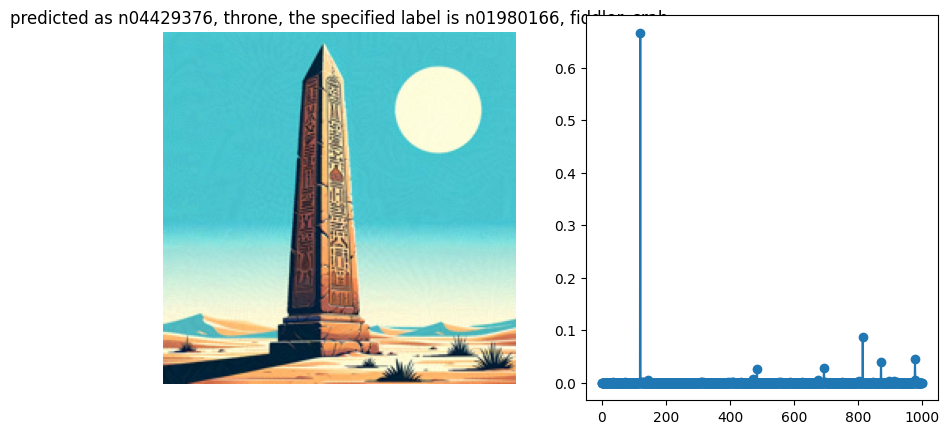

In [132]:


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_adv.numpy().transpose([1, 2, 0]))
plt.axis('off')
plt.title('predicted as ' + ', '.join(label_pred) + ', the specified label is ' + ', '.join(label_spec))

plt.subplot(1, 2, 2)
plt.plot(prob_adv,'-o')

In [133]:
idx_adv

120

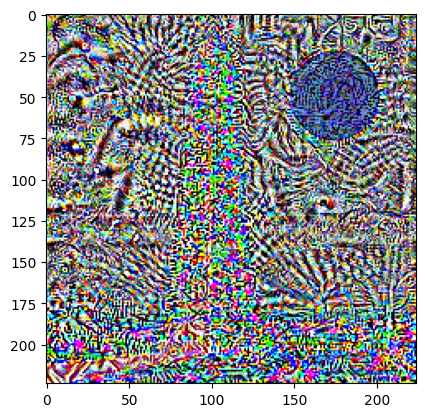

In [134]:
dx = x_adv.data - x.data
dx = (dx - dx.min())/(dx.max() - dx.min())
dx = dx.numpy().transpose([1, 2, 0])
plt.imshow(dx)